# nuScenes lidarseg and panoptic tutorial

Welcome to the nuScenes lidarseg and panoptic tutorial. The lidarseg and panoptic share quite many functions in the tutorial, so we put them into single tutorial. But you can opt to set up either the lidarseg or the panoptic dataset, and only run the portion for specific task.

This demo assumes that nuScenes is installed at `/data/sets/nuscenes`. The mini version (i.e. v1.0-mini) of the full dataset will be used for this demo.

## Setup
To install the nuScenes-lidarseg and/or Panoptic nuScenes expansion, download the dataset from https://www.nuscenes.org/download. Unpack the compressed file(s) into `/data/sets/nuscenes` and your folder structure should end up looking like this:
```
└── nuscenes  
    ├── Usual nuscenes folders (i.e. samples, sweep)
    │
    ├── lidarseg
    │   └── v1.0-{mini, test, trainval} <- Contains the .bin files; a .bin file 
    │                                      contains the labels of the points in a 
    │                                      point cloud (note that v1.0-test does not 
    │                                      have any .bin files associated with it)
    │
    ├── panoptic
    │   └── v1.0-{mini, test, trainval} <- Contains the *_panoptic.npz files; a .npz file 
    │                                      contains the panoptic labels of the points in a 
    │                                      point cloud (note that v1.0-test does not 
    │                                      have any .npz files associated with it) 
    └── v1.0-{mini, test, trainval}
        ├── Usual files (e.g. attribute.json, calibrated_sensor.json etc.)
        ├── lidarseg.json  <- contains the mapping of each .bin file to the token
        ├── panoptic.json  <- contains the mapping of each .npz file to the token       
        └── category.json  <- contains the categories of the labels (note that the 
                              category.json from nuScenes v1.0 is overwritten)
```

## Google Colab (optional) 

<br>
<a href="https://colab.research.google.com/github/nutonomy/nuscenes-devkit/blob/master/python-sdk/tutorials/nuscenes_lidarseg_panoptic_tutorial.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/ align="left">
</a>
<br>

If you are running this notebook in Google Colab, you can uncomment the cell below and run it; everything will be set up nicely for you. Otherwise, go to [**Setup**](#Setup) to manually set up everything.

Download and setup nuScenes-devkit for nuScenes-lidarseg dataset.

In [1]:
# !mkdir -p /data/sets/nuscenes  # Make the directory to store the nuScenes dataset in.

# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.
# !wget https://www.nuscenes.org/data/nuScenes-lidarseg-mini-v1.0.tar.bz2  # Download the nuScenes-lidarseg mini split.

# !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.
# !tar -xf nuScenes-lidarseg-mini-v1.0.tar.bz2 -C /data/sets/nuscenes   # Uncompress the nuScenes-lidarseg mini split.

# !pip install nuscenes-devkit &> /dev/null  # Install nuScenes.

Download and setup Panoptic nuScenes dataset.

In [2]:
# !wget https://www.nuscenes.org/data/v1.0-mini.tgz  # Download the nuScenes mini split.
# !wget https://www.nuscenes.org/data/nuScenes-panoptic-v1.0-mini.tar.gz  # Download the Panoptic nuScenes mini split.

# !tar -xf v1.0-mini.tgz -C /data/sets/nuscenes  # Uncompress the nuScenes mini split.
# !tar -xf nuScenes-panoptic-v1.0-mini.tar.gz -C /data/sets/nuscenes   # Uncompress the Panoptic nuScenes mini split.

## Initialization
Let's start by importing the necessary libraries:

In [3]:
%matplotlib inline

from nuscenes import NuScenes

nusc = NuScenes(version='v1.0-mini', dataroot='./../../data/sets/nuscenes', verbose=True)
# needed to revise to ./data/sets/nuscenes

Loading NuScenes tables for version v1.0-mini...
Loading nuScenes-lidarseg...
Loading nuScenes-panoptic...
32 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
404 lidarseg,
404 panoptic,
Done loading in 0.489 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


As you can see, you do not need any extra libraries to use nuScenes-lidarseg and Panoptic nuScenes. The original nuScenes devkit which you are familiar with has been extended so that you can use it seamlessly with nuScenes-lidarseg and Panoptic nuScenes.

## Point statistics of lidarseg/panoptic dataset for the v1.0-mini split
Let's get a quick feel of the lidarseg dataset by looking at what classes are in it and the number of points belonging to each class. The classes will be sorted in ascending order based on the number of points (since `sort_by='count'` below); you can also sort the classes by class name or class index by setting `sort_by='name'` or `sort_by='index'` respectively.

In [4]:
# nuscenes-lidarseg
nusc.list_lidarseg_categories(sort_by='count')

Calculating semantic point stats for nuScenes-lidarseg...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,412
 14  vehicle.bicycle                          nbr_points=       1,463
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

With `list_lidarseg_categories`, you can get the index which each class name belongs to by looking at the leftmost column. You can also get a mapping of the indices to the class names from the `lidarseg_idx2name_mapping` attribute of the NuScenes class.

In [5]:
nusc.lidarseg_idx2name_mapping

{0: 'noise',
 1: 'animal',
 2: 'human.pedestrian.adult',
 3: 'human.pedestrian.child',
 4: 'human.pedestrian.construction_worker',
 5: 'human.pedestrian.personal_mobility',
 6: 'human.pedestrian.police_officer',
 7: 'human.pedestrian.stroller',
 8: 'human.pedestrian.wheelchair',
 9: 'movable_object.barrier',
 10: 'movable_object.debris',
 11: 'movable_object.pushable_pullable',
 12: 'movable_object.trafficcone',
 13: 'static_object.bicycle_rack',
 14: 'vehicle.bicycle',
 15: 'vehicle.bus.bendy',
 16: 'vehicle.bus.rigid',
 17: 'vehicle.car',
 18: 'vehicle.construction',
 19: 'vehicle.emergency.ambulance',
 20: 'vehicle.emergency.police',
 21: 'vehicle.motorcycle',
 22: 'vehicle.trailer',
 23: 'vehicle.truck',
 24: 'flat.driveable_surface',
 25: 'flat.other',
 26: 'flat.sidewalk',
 27: 'flat.terrain',
 28: 'static.manmade',
 29: 'static.other',
 30: 'static.vegetation',
 31: 'vehicle.ego'}

Conversely, you can get the mapping of the class names to the indices from the `lidarseg_name2idx_mapping` attribute of the NuScenes class.

In [6]:
nusc.lidarseg_name2idx_mapping

{'noise': 0,
 'animal': 1,
 'human.pedestrian.adult': 2,
 'human.pedestrian.child': 3,
 'human.pedestrian.construction_worker': 4,
 'human.pedestrian.personal_mobility': 5,
 'human.pedestrian.police_officer': 6,
 'human.pedestrian.stroller': 7,
 'human.pedestrian.wheelchair': 8,
 'movable_object.barrier': 9,
 'movable_object.debris': 10,
 'movable_object.pushable_pullable': 11,
 'movable_object.trafficcone': 12,
 'static_object.bicycle_rack': 13,
 'vehicle.bicycle': 14,
 'vehicle.bus.bendy': 15,
 'vehicle.bus.rigid': 16,
 'vehicle.car': 17,
 'vehicle.construction': 18,
 'vehicle.emergency.ambulance': 19,
 'vehicle.emergency.police': 20,
 'vehicle.motorcycle': 21,
 'vehicle.trailer': 22,
 'vehicle.truck': 23,
 'flat.driveable_surface': 24,
 'flat.other': 25,
 'flat.sidewalk': 26,
 'flat.terrain': 27,
 'static.manmade': 28,
 'static.other': 29,
 'static.vegetation': 30,
 'vehicle.ego': 31}

## Pick a sample token
Let's pick a sample to use for this tutorial.

In [7]:
my_sample = nusc.sample[87]

For Panoptic nuScenes, it shares the same member variables `lidarseg_idx2name_mapping` and `lidarseg_names2idx_mapping` with nuScenes-lidarseg. Similarly, you can check the number of points for each semantic category from the Panoptic nuScenes dataset. The only thing to do is add `gt_from='panoptic'` argument. By default, `gt_from='lidarseg'`.

You might have noticed the point numbers for certain categories vary slightly between lidarseg and panoptic dataset. The reason is the overlapping points between instances are set to noise (category 0) in Panoptic nuScenes. You can see the increased number of points for `noise` category in Panoptic nuScenes, and the total point number remains the same.

## Instance statistics of panoptic dataset  for the v1.0-mini split

Instances statistics are specific to panoptic dataset. We provide `list_panoptic_instances()` function for this purpose. You can set the `sort_by` to one of `['count', 'index', 'name']`. The function will calculate the number of instances per frame, total number of instances (unique object ID) and instance states (one instance could have more than one states, a.k.a, a track). Also it calculates the per-category statistics, including the mean and standard deviation for number of frames an instance spans, and mean and standard deviation for number of points per instance.

Note only thing categories have instances. The point statistics could refer to the point statistics section.

In [8]:
nusc.list_panoptic_instances(sort_by='count')

Calculating instance stats for nuScenes-panoptic ...
Per-frame number of instances: 39±24
Per-category instance stats:
vehicle.car: 382 instances, each instance spans to 15±11 frames, with 89±281 points
human.pedestrian.adult: 221 instances, each instance spans to 19±11 frames, with 10±19 points
movable_object.trafficcone: 106 instances, each instance spans to 8±7 frames, with 7±17 points
movable_object.barrier: 92 instances, each instance spans to 20±12 frames, with 29±70 points
vehicle.truck: 32 instances, each instance spans to 23±13 frames, with 420±1534 points
vehicle.motorcycle: 22 instances, each instance spans to 18±9 frames, with 17±36 points
vehicle.bus.rigid: 20 instances, each instance spans to 20±13 frames, with 73±150 points
vehicle.bicycle: 19 instances, each instance spans to 13±8 frames, with 6±12 points
human.pedestrian.construction_worker: 10 instances, each instance spans to 16±9 frames, with 9±15 points
vehicle.construction: 9 instances, each instance spans to 30±1

## Get statistics of a lidarseg/panoptic sample token
Now let's take a look at what classes are present in the pointcloud of this particular sample.

In [9]:
# Panoptic nuScenes
nusc.list_lidarseg_categories(sort_by='count', gt_from='panoptic')

Calculating semantic point stats for nuScenes-panoptic...
  1  animal                                   nbr_points=           0
  7  human.pedestrian.stroller                nbr_points=           0
  8  human.pedestrian.wheelchair              nbr_points=           0
 19  vehicle.emergency.ambulance              nbr_points=           0
 20  vehicle.emergency.police                 nbr_points=           0
 10  movable_object.debris                    nbr_points=          48
  6  human.pedestrian.police_officer          nbr_points=          64
  3  human.pedestrian.child                   nbr_points=         230
  4  human.pedestrian.construction_worker     nbr_points=       1,401
 14  vehicle.bicycle                          nbr_points=       1,460
 11  movable_object.pushable_pullable         nbr_points=       2,293
  5  human.pedestrian.personal_mobility       nbr_points=       4,096
 13  static_object.bicycle_rack               nbr_points=       4,476
 12  movable_object.trafficcone 

In [10]:
# nuscenes-lidarseg
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count')

===== Statistics for 6dabc0fb1df045558f802246dd186b3f =====
 14  vehicle.bicycle                          n=           9
 11  movable_object.pushable_pullable         n=          11
  0  noise                                    n=          62
  2  human.pedestrian.adult                   n=          71
 16  vehicle.bus.rigid                        n=         105
  9  movable_object.barrier                   n=         280
 22  vehicle.trailer                          n=         302
 30  static.vegetation                        n=         330
 23  vehicle.truck                            n=       1,229
 26  flat.sidewalk                            n=       1,310
 25  flat.other                               n=       1,495
 17  vehicle.car                              n=       3,291
 28  static.manmade                           n=       4,650
 24  flat.driveable_surface                   n=       9,884
 31  vehicle.ego                              n=      11,723


By doing `sort_by='count'`, the classes and their respective frequency counts are printed in ascending order; you can also do `sort_by='name'` and `sort_by='index'` here as well.

Similarly, we can use the same function to get the category frequency counts using the panoptic dataset by adding `gt_from='panoptic'`. As mentioned in `list_lidarseg_categories()`, the point count might be slightly different to lidarseg, due to the overlapping points of multiple instances are set to `noise` in Panoptic nuScenes.

In [11]:
# Panoptic nuScenes
nusc.get_sample_lidarseg_stats(my_sample['token'], sort_by='count', gt_from='panoptic')

===== Statistics for 6dabc0fb1df045558f802246dd186b3f =====
 14  vehicle.bicycle                          n=           9
 11  movable_object.pushable_pullable         n=          11
  0  noise                                    n=          62
  2  human.pedestrian.adult                   n=          71
 16  vehicle.bus.rigid                        n=         105
  9  movable_object.barrier                   n=         280
 22  vehicle.trailer                          n=         302
 30  static.vegetation                        n=         330
 23  vehicle.truck                            n=       1,229
 26  flat.sidewalk                            n=       1,310
 25  flat.other                               n=       1,495
 17  vehicle.car                              n=       3,291
 28  static.manmade                           n=       4,650
 24  flat.driveable_surface                   n=       9,884
 31  vehicle.ego                              n=      11,723


## Render the lidarseg labels in the bird's eye view of a pointcloud
In the original nuScenes devkit, you would pass a sample data token into ```render_sample_data``` to render a bird's eye view of the pointcloud. However, the points would be colored according to the distance from the ego vehicle. Now with the extended nuScenes devkit, all you need to do is set ```show_lidarseg=True``` to visualize the class labels of the pointcloud.

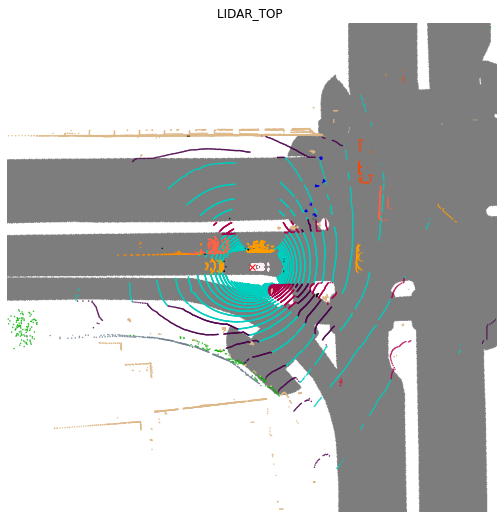

In [12]:
sample_data_token = my_sample['data']['LIDAR_TOP']
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True)

But what if you wanted to focus on only certain classes? Given the statistics of the pointcloud printed out previously, let's say you are only interested in trucks and trailers. You could see the class indices belonging to those classes from the statistics and then pass an array of those indices into ```filter_lidarseg_labels``` like so:

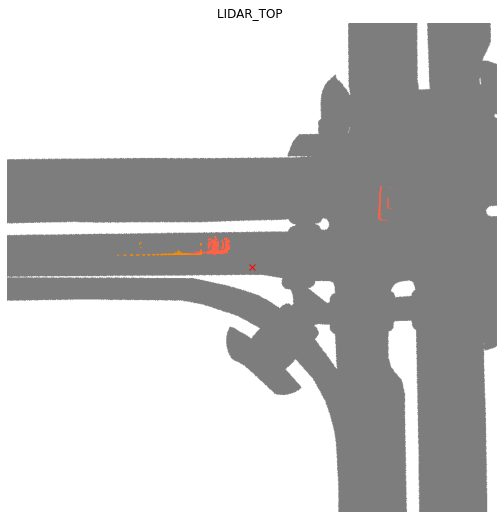

In [13]:
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True,
                        filter_lidarseg_labels=[22, 23])

Now only points in the pointcloud belonging to trucks and trailers are filtered out for your viewing pleasure. 

In addition, you can display a legend which indicates the color for each class by using `show_lidarseg_legend`.

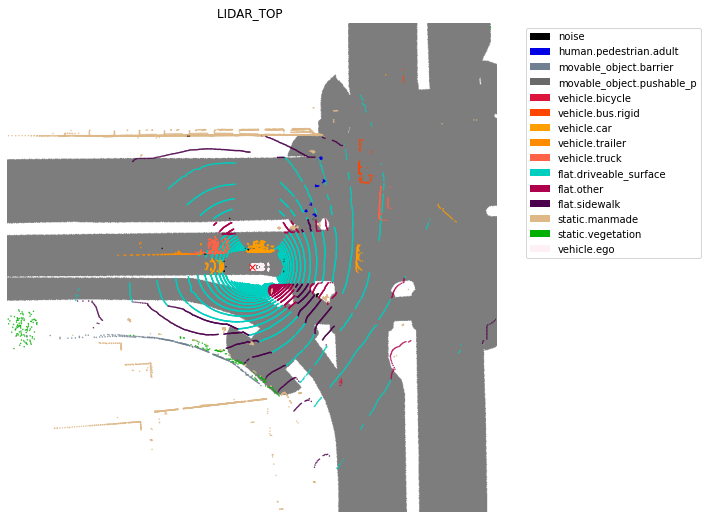

In [14]:
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=True,
                        show_lidarseg_legend=True)

## Render the panoptic labels in the bird's eye view of a pointcloud

Similar to lidarseg, the same function is used to render the panoptic labels. The argument difference is `show_panoptic=True`. By default, both `show_lidarseg` and `show_panoptic` are set to `False`. If both are set to `True`, i.e. `show_lidarseg=True, show_panoptic=True`, lidarseg will have the priority to render.

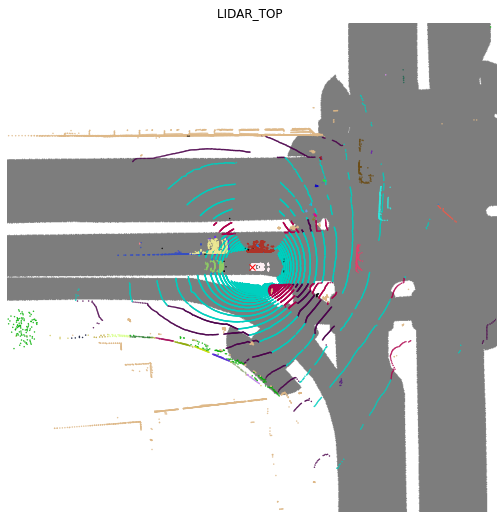

In [15]:
sample_data_token = my_sample['data']['LIDAR_TOP']
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=False,
                        show_panoptic=True)

You can see different vehicle instances from the same category will be displayed with unique colors. Similarly, you can play with the `filter_lidarseg_labels` and `show_lidarseg_legend=True` to show panoptic labels for certain thing and stuff categories, and the category legends. Note these 2 arguments are shared between lidarseg and panoptic datasets as well. Only legends of stuff categories will be displayed as the thing instances of same category have different colors. 

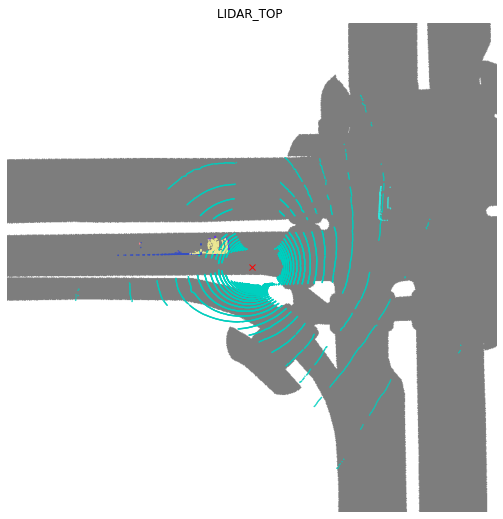

In [16]:
# show trucks, trailers and drivable_surface
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_panoptic=True,
                        filter_lidarseg_labels=[22, 23, 24])

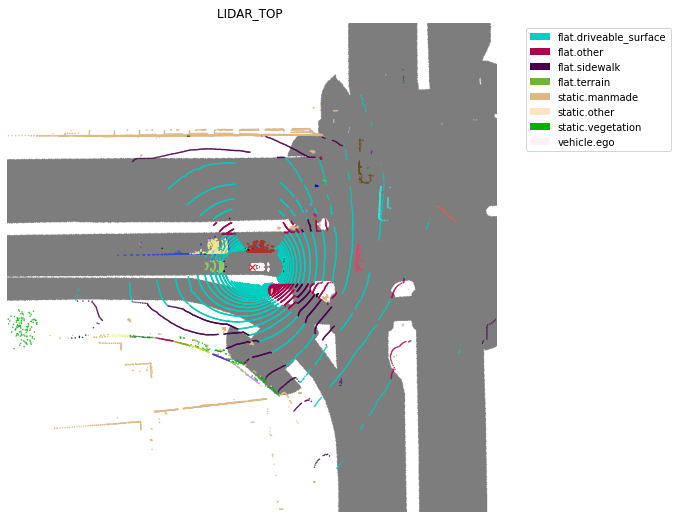

In [17]:
# show stuff category legends
nusc.render_sample_data(sample_data_token,
                        with_anns=False,
                        show_lidarseg=False,
                        show_lidarseg_legend=True,
                        show_panoptic=True)

## Render lidarseg/panoptic labels in image
If you wanted to superimpose the pointcloud into the corresponding image from a camera, you can use ```render_pointcloud_in_image``` like what you would do with the original nuScenes devkit, but set ```show_lidarseg=True``` (remember to set ```render_intensity=False```). Similar to ```render_sample_data```, you can filter to see only certain classes using ```filter_lidarseg_labels```. And you can use ```show_lidarseg_legend``` to display a legend in the rendering.

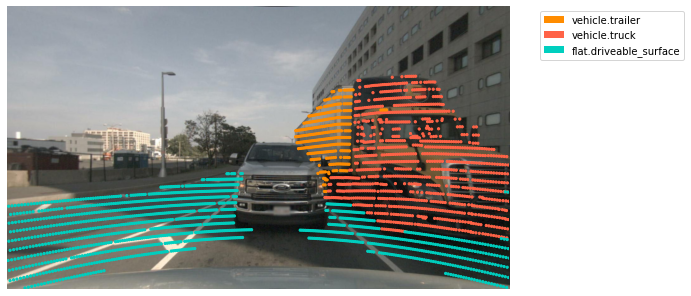

In [18]:
# nuscenes-lidarseg
nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=True,
                                filter_lidarseg_labels=[22, 23, 24],
                                show_lidarseg_legend=True)

Again, this function supports `show_panoptic=True` mode, panoptic labels will be displayed rather than semantic labels. Only legends for stuff categories will be displayed.

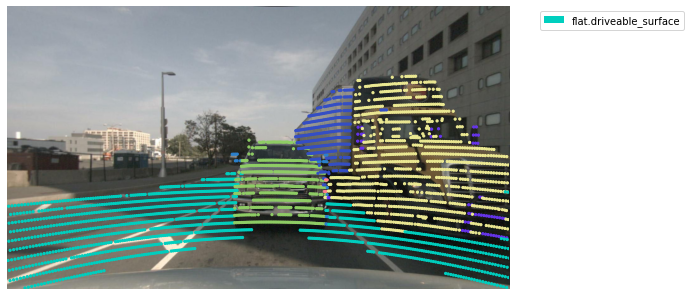

In [19]:
# Panoptic nuScenes
nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=False,
                                filter_lidarseg_labels=[17,22, 23, 24],
                                show_lidarseg_legend=True,
                                show_panoptic=True)

## Render sample (i.e. lidar, radar and all cameras)
Of course, like in the original nuScenes devkit, you can render all the sensors at once with ```render_sample```. In this extended nuScenes devkit, you can set ```show_lidarseg=True``` to see the lidarseg labels. Similar to the above methods, you can use ```filter_lidarseg_labels``` to display only the classes you wish to see.

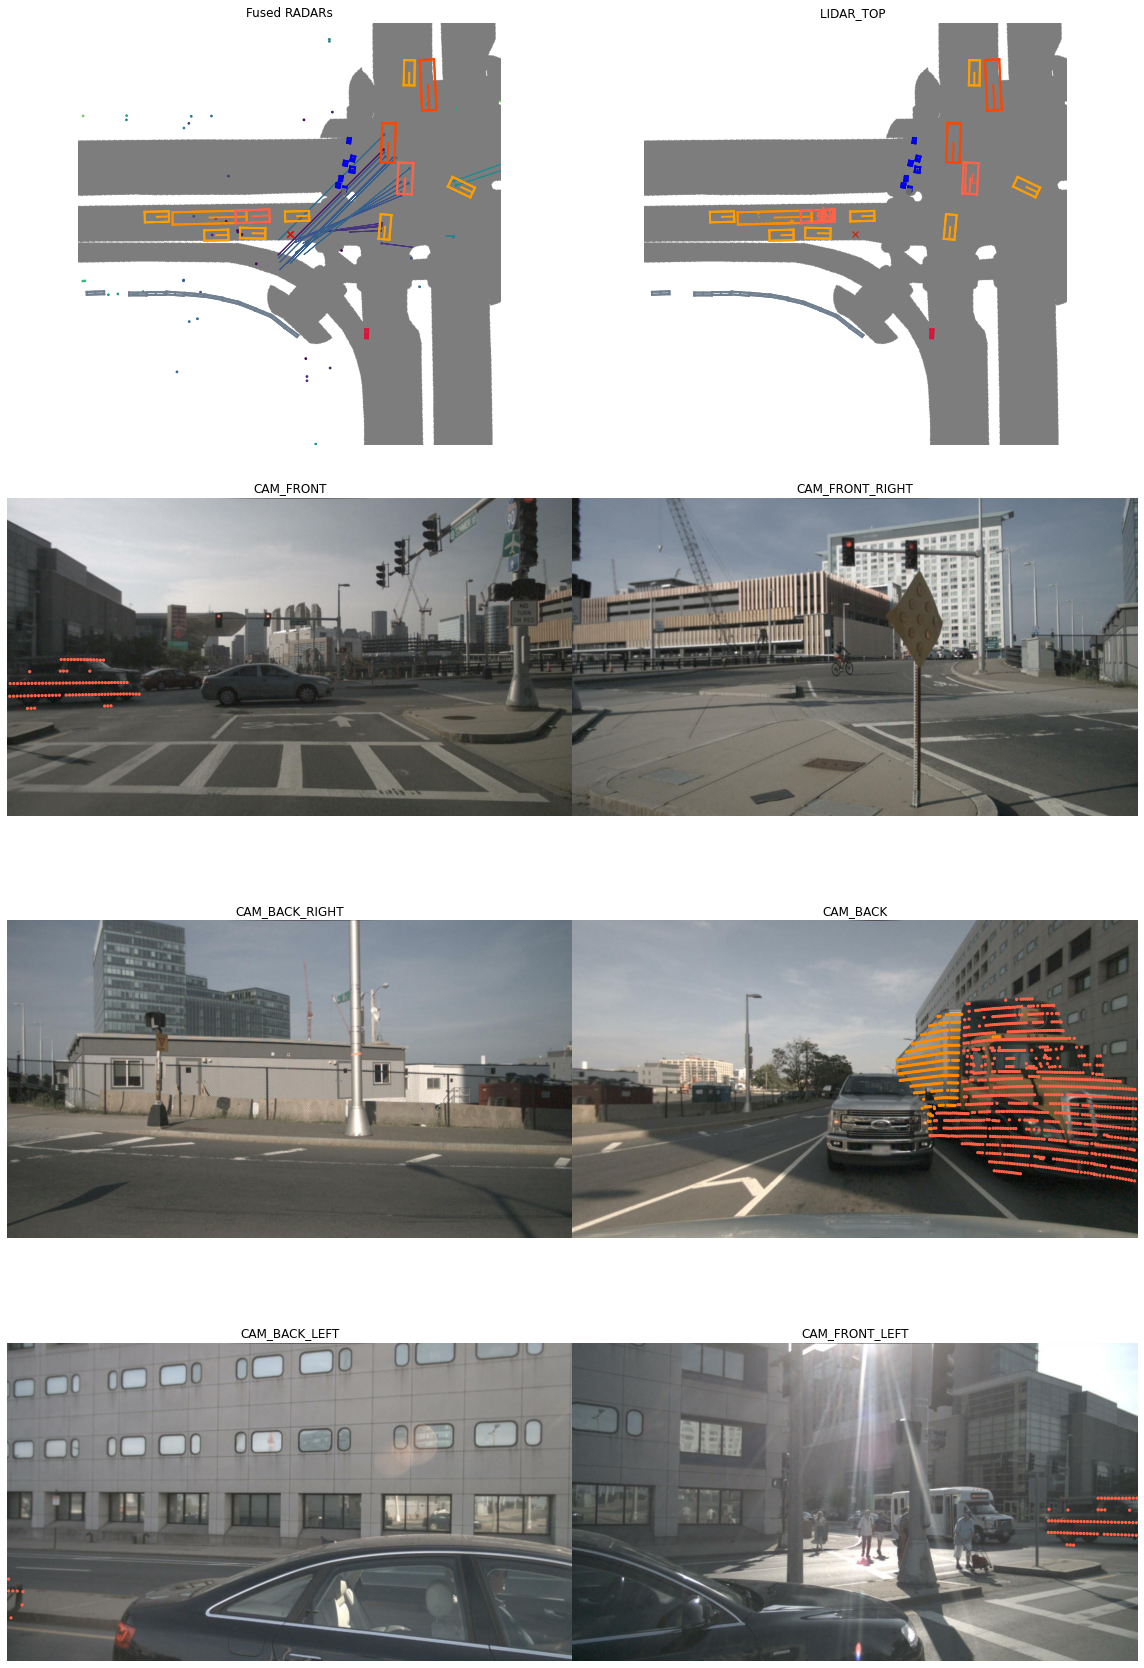

In [20]:
# nuscenes-lidarseg
nusc.render_sample(my_sample['token'],
                   show_lidarseg=True,
                   filter_lidarseg_labels=[22, 23])

To show panoptic labels with `render_sample`, set `show_panoptic=True`

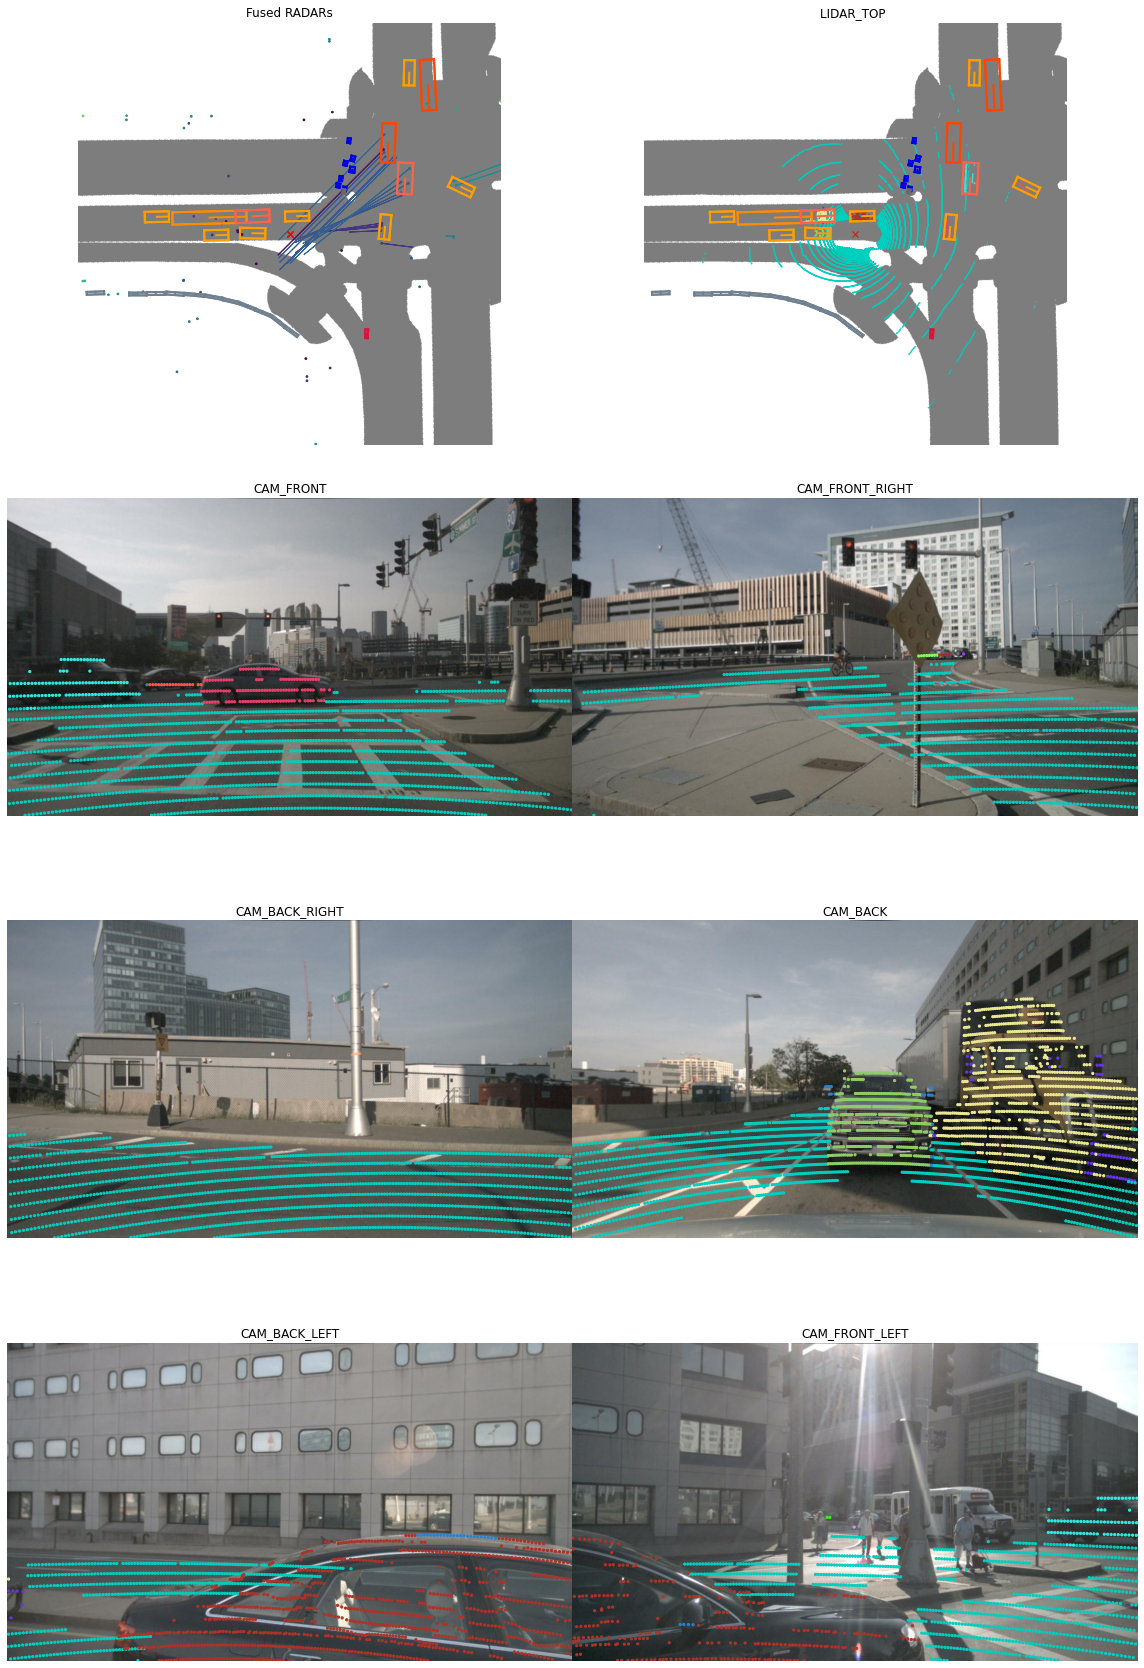

In [21]:
# Panoptic nuScenes
nusc.render_sample(my_sample['token'],
                   show_lidarseg=False,
                   filter_lidarseg_labels=[17, 23, 24],
                   show_panoptic=True)

## Render a scene for a given camera sensor with lidarseg/panoptic labels
You can also render an entire scene with the lidarseg labels for a camera of your choosing (the ```filter_lidarseg_labels``` argument can be used here as well).

Let's pick a scene first:

In [22]:
my_scene = nusc.scene[0]

We then pass the scene token into ```render_scene_channel_lidarseg``` indicating that we are only interested in construction vehicles and man-made objects (here, we set `verbose=True` to produce a window which will allows us to see the frames as they are being random). 

In addition, you can use `dpi` (to adjust the size of the lidar points) and `imsize` (to adjust the size of the rendered image) to tune the aesthetics of the renderings to your liking.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [23]:
# # nuscenes-lidarseg
# import os
# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[18, 28],
#                                    verbose=True, 
#                                    dpi=100,
#                                    imsize=(1280, 720))

This function also works for panoptic labels, by adding `show_panoptic=True`

In [24]:
# # # Panoptic nuScenes
# import os
# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[18, 24, 28],
#                                    verbose=True, 
#                                    dpi=100,
#                                    imsize=(1280, 720),
#                                    show_panoptic=True)

To save the renderings, you can pass a path to a folder you want to save the images to via the ```out_folder``` argument, and either `video` or `image` to `render_mode`.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [25]:
# # nuscenes-lidarseg
# nusc.render_scene_channel_lidarseg(my_scene['token'],
#                                    'CAM_BACK',
#                                    filter_lidarseg_labels=[18, 28],
#                                    verbose=True,
#                                    dpi=100,
#                                    imsize=(1280, 720),
#                                    render_mode='video',
#                                    out_folder=os.path.expanduser('~/Desktop/my_folder'))

When `render_mode='image'`, only frames which contain points (after the filter has been applied) will be saved as images.

Also the same function can be used to render scene channel for panoptic.

In [26]:
# # Panoptic nuScenes
# nusc.render_scene_channel_lidarseg(my_scene['token'],
#                                    'CAM_BACK',
#                                    filter_lidarseg_labels=[18, 24, 28],
#                                    verbose=True,
#                                    dpi=100,
#                                    imsize=(1280, 720),
#                                    render_mode='video',
#                                    out_folder=os.path.expanduser('~/Desktop/my_folder'),
#                                    show_panoptic=True)

## Render a scene for all cameras with lidarseg/panoptic labels
You can also render the entire scene for all cameras at once with the lidarseg labels as a video. Let's say in this case, we are interested in points belonging to driveable surfaces and cars.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [27]:
# # nuscenes-lidarseg
# nusc.render_scene_lidarseg(my_scene['token'], 
#                            filter_lidarseg_labels=[17, 24],
#                            verbose=True,
#                            dpi=100,
#                            out_path=os.path.expanduser('~/Desktop/my_rendered_scene.avi'))

Again, we can render a scene for panoptic labels.

In [28]:
# # Panoptic nuScenes
# nusc.render_scene_lidarseg(my_scene['token'], 
#                            filter_lidarseg_labels=[17, 24],
#                            verbose=True,
#                            dpi=100,
#                            out_path=os.path.expanduser('~/Desktop/my_rendered_scene.avi')
#                            show_panoptic=True)

## Visualizing LiDAR segmentation predictions
In all the above functions, the labels of the LiDAR pointcloud which have been rendered are the ground truth. If you have trained a model to segment LiDAR pointclouds and have run it on the nuScenes-lidarseg dataset, you can visualize your model's predictions with nuScenes-lidarseg as well!

Each of your .bin files should be a `numpy.uint8` array; as a tip, you can save your predictions as follows:
```
np.array(predictions).astype(np.uint8).tofile(bin_file_out)
```
- `predictions`: The predictions from your model (e.g. `[30, 5, 18, ..., 30]`)
- `bin_file_out`: The path to write your .bin file to (e.g. `/some/folder/<lidar_sample_data_token>_lidarseg.bin`)

Then you simply need to pass the path to the .bin file where your predictions for the given sample are to `lidarseg_preds_bin_path` for these functions:
- `list_lidarseg_categories`
- `render_sample_data`
- `render_pointcloud_in_image`
- `render_sample`                 

For example, let's assume the predictions for `my_sample` is stored at `/data/sets/nuscenes/lidarseg/v1.0-mini` with the format `<lidar_sample_data_token>_lidarseg.bin`:

In [30]:
import os

my_sample = nusc.sample[87]
sample_data_token = my_sample['data']['LIDAR_TOP']
my_predictions_bin_file = os.path.join('/data/sets/nuscenes/lidarseg/v1.0-mini', sample_data_token + '_lidarseg.bin')

nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=True,
                                filter_lidarseg_labels=[22, 23],
                                show_lidarseg_legend=True,
                                lidarseg_preds_bin_path=my_predictions_bin_file)

AssertionError: Error: Unable to find /data/sets/nuscenes/lidarseg/v1.0-mini/d219ffa9b4ce492c8b8059db9d8b3166_lidarseg.bin to load the predictions for sample token 6dabc0fb1df045558f802246dd186b3f (lidar sample data token d219ffa9b4ce492c8b8059db9d8b3166) from.

For these functions that render an entire scene, you will need to pass the path to the folder which contains the .bin files for each sample in a scene to `lidarseg_preds_folder`:
- `render_scene_channel_lidarseg`
- `render_scene_lidarseg`

Pay special attention that **each set of predictions in the folder _must_ be a `.bin` file and named as `<lidar_sample_data_token>_lidarseg.bin`**.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# my_scene = nusc.scene[0]
# my_folder_of_predictions = '/data/sets/nuscenes/lidarseg/v1.0-mini'

# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[17, 24],
#                                    verbose=True, 
#                                    imsize=(1280, 720),
#                                    lidarseg_preds_folder=my_folder_of_predictions)

## Visualize LiDAR panoptic predictions

Similarly, panoptic prediction results could be rendered as well!
Each of your .npz files should be a compressed `numpy.uint16` array; You can save your predictions as follows:
```
np.savez_compressed(npz_file_out, data=predictions.astype(np.uint16))
```
- `predictions`: The predictions from your model (e.g. `[1030, 15005, 180, ..., 3030]`, the `panoptic label = category_id * 1000 + instance_id`, the instance_id is unique, i.e. `[1, 2, 3, ..., 999]` within each scene).
- `bin_file_out`: The path to write your .npz file to (e.g. `/some/folder/<lidar_sample_data_token>_panoptic.npz`). Note 

Then you simply need to pass the path to the .npz file where your predictions for the given sample are to `lidarseg_preds_bin_path` (Note the path name is correct as we share these arguments with `nuscenes-lidarseg` predictions) for these functions:
- `list_lidarseg_categories`
- `render_sample_data`
- `render_pointcloud_in_image`
- `render_sample`                 

For example, let's assume the predictions for `my_sample` is stored at `/data/sets/nuscenes/panoptic/v1.0-mini` with the format `<lidar_sample_data_token>_panoptic.npz`:

In [31]:
import os

my_sample = nusc.sample[87]
sample_data_token = my_sample['data']['LIDAR_TOP']
my_predictions_bin_file = os.path.join('/data/sets/nuscenes/panoptic/v1.0-mini', sample_data_token + '_panoptic.npz')

nusc.render_pointcloud_in_image(my_sample['token'],
                                pointsensor_channel='LIDAR_TOP',
                                camera_channel='CAM_BACK',
                                render_intensity=False,
                                show_lidarseg=False,
                                filter_lidarseg_labels=[17,22, 23, 24],
                                show_lidarseg_legend=True,
                                lidarseg_preds_bin_path=my_predictions_bin_file,
                                show_panoptic=True)

AssertionError: Error: Unable to find /data/sets/nuscenes/panoptic/v1.0-mini/d219ffa9b4ce492c8b8059db9d8b3166_panoptic.npz to load the predictions for sample token 6dabc0fb1df045558f802246dd186b3f (lidar sample data token d219ffa9b4ce492c8b8059db9d8b3166) from.

For these functions that render an entire scene, you will need to pass the path to the folder which contains the .npz files for each sample in a scene to `lidarseg_preds_folder`:
- `render_scene_channel_lidarseg`
- `render_scene_lidarseg`

Pay special attention that **each set of predictions in the folder _must_ be a `.npz` file and named as `<lidar_sample_data_token>_panoptic.npz`**.

(Note: the following code is commented out as it crashes in Jupyter notebooks.)

In [ ]:
# my_scene = nusc.scene[0]
# my_folder_of_predictions = '/data/sets/nuscenes/panoptic/v1.0-mini'

# nusc.render_scene_channel_lidarseg(my_scene['token'], 
#                                    'CAM_BACK', 
#                                    filter_lidarseg_labels=[9, 18, 24, 28],
#                                    verbose=True, 
#                                    imsize=(1280, 720),
#                                    lidarseg_preds_folder=my_folder_of_predictions,
#                                    show_panoptic=True)

## Conclusion
And this brings us to the end of the tutorial for nuScenes-lidarseg and Panoptic nuScenes, enjoy!